# Data 620: Project 2
## St. Louis Crime
### Aaron Grzasko
### 10/14/2018

## Assignment Instructions

The instructions for Project 2 are as follows:  

1. Find a 2-mode network in a network repository,
2. Reduce the size of the network using a a method such as the island method,
3. What can you infer about the distinct groups?

## Dataset Overview

For this assignment, I analyze the *Rosenfield, White St. Louis* Crime dataset.  
The data were initially collected in the 1990s by reviewing police records related to five homicides.  The researchers recorded all individuals associated with the five crimes--including suspects, witnesses and victims.  Using a snowball sampling procedure on the initial individuals, the researchers were able to collect data related to many additional crime events. 

The crime data set can be represented as a bipartite network with the following two node types:
* crime event
* individuals associated with crime

Edges between distinct node types are used to indicate individuals associated with a particular crime.

A more detailed description of the dataset can be found [here](http://moreno.ss.uci.edu/data.html#crime).  

## Read/Scrub Data

In [1]:
# import libraries
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import urllib.request
import warnings
from networkx.algorithms import bipartite

# initial settings
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# download data from web
url = 'http://moreno.ss.uci.edu/crime.dat'
urllib.request.urlretrieve(url,'crime.dat' )


('crime.dat', <http.client.HTTPMessage at 0x22f71e28780>)

In [3]:
# assign row and column names, using data provided in the .dat file 
row_names = np.genfromtxt('crime.dat', dtype=None, delimiter='\n', \
                          encoding=None)[4:874]
col_names = np.genfromtxt('crime.dat', dtype=None, delimiter='\n', \
                          encoding=None)[875:1432]

# clean up column names by removing quotes  
col_names =  np.char.replace(col_names, '"', '')

# clean up row names by removing quotes  
row_names =  np.char.replace(row_names, '"', '')

Fortunately, the column entries do not appear to be duplicated; so we can simply adjust the offending labels.  In the snippet below, we fix the duplicate entries by replacing the initial digit from a '9' to a '8'.  This works because all original crime identifiers begin with the digit '9'. 

In [4]:
# fix duplicate entries
col_names = " ".join(col_names)
col_names = col_names.replace('960247','860247',1)
col_names = col_names.replace('960267','860267',1)
col_names = np.array(col_names.split(' '))

# print remaining duplicate entries, if any
s = pd.Series(col_names)
print('duplicate labels: ')
print(s[s.duplicated()])


duplicate labels: 
Series([], dtype: object)


Now let's read in the datset as a pandas DataFrame:  

In [5]:
# read in data matrix as pandas dataframe
df = pd.read_csv('crime.dat', skiprows = 1433, delimiter = ' ', \
                 header=None, names=col_names)
# set row names
df = df.set_index(row_names)

# print dimensions of dataframe
df.shape

(870, 557)

The dataframe contains 870 rows, which represent unique individuals involved in crimes. Individuals are denoted by the concatenation of their last and first names, respectively.  

The 557 columns represent unique crime events.  Crimes are denoted by unique 6 digit identifier. 

Let's look at the first entries in the Data Frame:

In [6]:
df.iloc[:,0:15].head(10)

,920001,930002,930003,930004,930005,930006,930007,930008,930009,930010,930011,930012,930013,930014,930015
AbelDennis,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AbramsChad,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AbramsDavid,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AbramsDon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AbramsRichard,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AdamsCurtis,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AdamsMartha,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AdamsReggie,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AlexanderDevon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AlexanderNolan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


The DataFrame is storing the network data in form of an adjacency matrix.  While not visually apparent in the  portion of the matrix presented above, the matrix uses a specific coding structure to indicate an individual's involvement in a crime:
  
 * 0: no involvement in crime
 * 1: victim
 * 2: suspect
 * 3: witness
 * 4: victim and suspect

Finally, let's clean up some of the entries in our adjacency matrix.  We noticed that some zero values were coded as strings (i.e. "0").  Other values were coded as "?".  Let's replace these instance with a zero value, indicating no crime involvement.

In [7]:
# convert "?" and "0" string values to 0  
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        if isinstance(df.iloc[i,j], str):
            df.iloc[i,j] = 0

## Create Graphs

**Initial Bipartite Graph**

Let's take an initial look at the network.  In the bipartite graph below, we use the blue color to denote people, and a green color to represent crimes.  We assume a connection exists between a crime and a person node if the person was involved in the crime in any capacity (i.e. suspect, witness, victim, etc.)

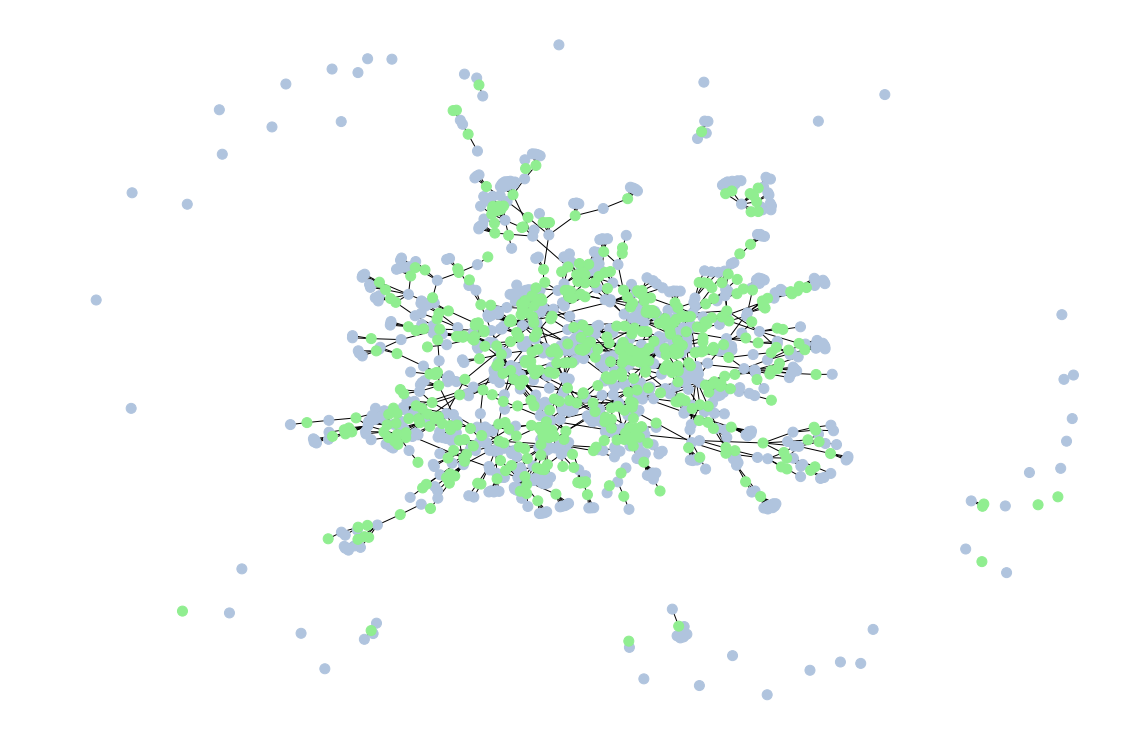

In [8]:
# initialize graph
G = nx.Graph()

# add nodes for each partition: 
G.add_nodes_from(row_names, bipartite='people')
G.add_nodes_from(col_names, bipartite='crimes')

# create edges; load to graph; assume connection if matrix value is > 0
edges = [(row, col) for row in \
         row_names for col in col_names \
         if df.loc[row,col] > 0]

# add edges to graph
G.add_edges_from(edges)

# separate out two nodes
X =  {n for n, d in G.nodes(data=True) if d['bipartite']=='people'}
Y =  set(G) - X
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(X) ) 
pos.update( (n, (2, i)) for i, n in enumerate(Y) ) 

# list of bipartite partition category (i.e. women/event) for each node
c = [d['bipartite'] for n,d in G.nodes(data=True)]

# specify separate colors for each node type
col_values = ['lightsteelblue' if i== 'people' else 'lightgreen' for i in c]

# draw bipartite graph
plt.figure(figsize=(15,10)) 
nx.draw(G, node_color = col_values, \
        width=1, node_size = 100)

plt.show()


**Bipartite Graph: Observations and Metrics**

In [9]:
# basic bipartite graph metrics
print("number of nodes:",  len(nx.nodes(G)))
print("number of people nodes:",  len([n for n in G.nodes() if G.node[n]['bipartite'] == 'people']))
print("number of crime nodes:",  len([n for n in G.nodes() if G.node[n]['bipartite'] == 'crimes']))
print("number of edges:",  len(nx.edges(G)))

number of nodes: 1427
number of people nodes: 870
number of crime nodes: 557
number of edges: 1487


We see a significant number of people nodes that are not connected to any crime nodes, and a handful of crime nodes that are not connected to any people nodes. There are also a handful of people-crime clusters that are not connected to the larger graph.  Note: metrics such as graph diameter are not relevant to the entire graph because it is disconnected; however we can produce a graph diameter for the largest connected subgraph.  

Let's see how many nodes are isolated in this graph:

In [10]:
# isolated nodes
print('number of isolated vertices: ',len([i for i in nx.connected_component_subgraphs(G) if len(i) == 1]))


number of isolated vertices:  44


Now let's look at the size connected subgraphs that feature at least 2 nodes:

In [11]:
# connected subgraphs with > 1 node
print('component subgraph sizes larger than 1:')
print(sorted([len(i) for i in nx.connected_component_subgraphs(G) if len(i.nodes()) > 1], reverse = True))


component subgraph sizes larger than 1:
[1263, 30, 20, 18, 13, 9, 7, 6, 5, 4, 3, 3, 2]


There are 13 connected subgraphs that meet this definition.  Let's view the largest connected component subgraph:   

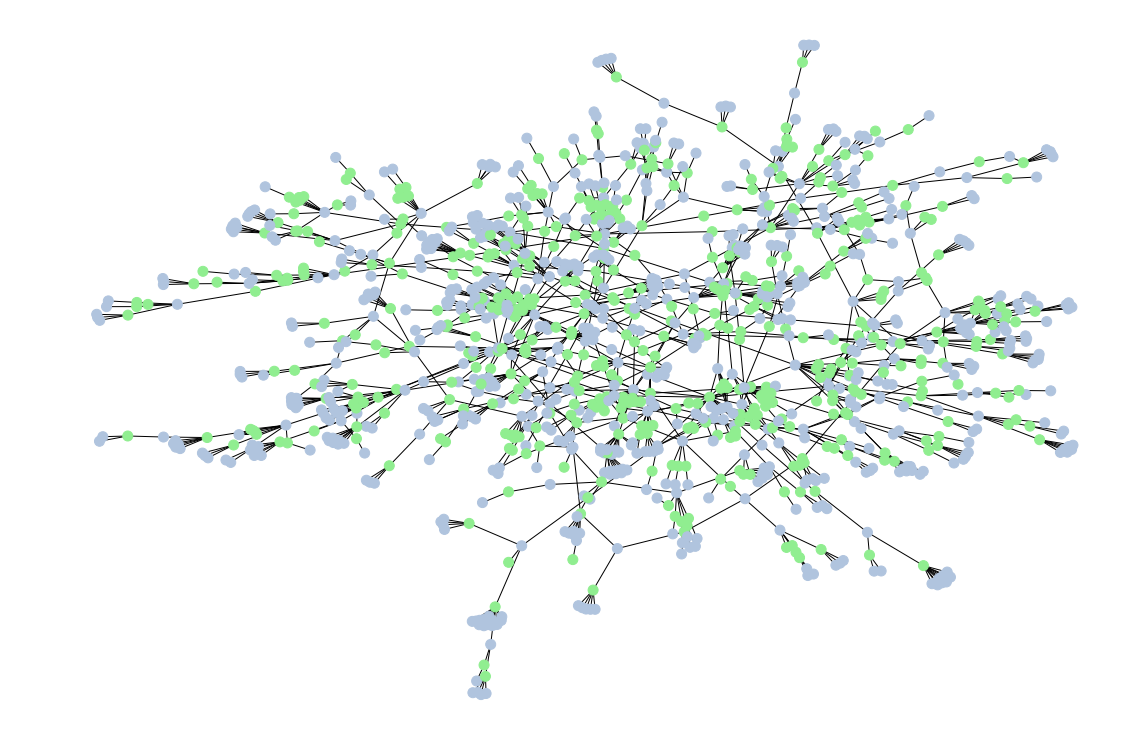

In [12]:
# largest component subgraph
largest_sub = [i for i in nx.connected_component_subgraphs(G) if len(i.nodes()) == 1263][0]

# list of bipartite partition category (i.e. people/crime) for each node
c = [d['bipartite'] for n,d in largest_sub.nodes(data=True)]

# specify separate colors for each node type
col_values = ['lightsteelblue' if i== 'people' else 'lightgreen' for i in c]

# draw bipartite graph
plt.figure(figsize=(15,10)) 
nx.draw(largest_sub, node_color = col_values, \
        width=1, node_size = 100)

plt.show()


Based on this subgraph, it appears that most crimes involve more than one individual.  Also, we see many individuals associated with more than one crime.

In [13]:
# print graph diameter for largest connected subgraph
print('subgraph diameter:')
print(nx.diameter(largest_sub))

subgraph diameter:
32


**People Metrics In Bipartite Graph**

Let's review degree centrality and degree measures for people nodes in the bipartite graph.

In [14]:
# calculate degree for graph
d = sorted([round(v,3) for k,v in dict(nx.degree(G)).items() \
        if G.node[k]['bipartite'] == 'people'], reverse=True)


# calculate people degree centrality in bipartite graph
dc = sorted([round(v,3) for k,v in nx.degree_centrality(G).items() \
        if G.node[k]['bipartite'] == 'people'],reverse=True)

# people in sorted order by degree centrality
p = sorted([(k,round(v,3)) for k,v in nx.degree_centrality(G).items() \
        if G.node[k]['bipartite'] == 'people'],
       key= lambda z: z[1], reverse=True)
p = [name for name,val in p ]


# save degree metrics to df
peopledf = pd.DataFrame({'people':p, 'degree_cent':dc, 'degree':d})

# top 10 people by degree cent and degree measures
peopledf[0:10]

,people,degree_cent,degree
0,WilsonMac,0.018,25
1,AbramsChad,0.015,22
2,KeaneArthur,0.013,18
3,DicksonCarter,0.012,17
4,BendixJerryLee,0.010,14
5,HemphillButch,0.008,12
6,McConnellPhyllis,0.008,11
7,MinionMaggie,0.008,11
8,SmothersFreddie,0.008,11
9,StevensRico,0.008,11


The degree centrality measures are fairly low overall.  This makes sense, as we would not expect most people to be involved in hundreds different crimes.  In fact, we see that our the top 10 nodes are associated between 11 and 25 different crimes.  The bottom 10 individuals were not associated with any crimes.

Below is distribution of people nodes by crime degree counts.  The histogram is right skewed, with the vast majority of individuals involved with only or two crimes; while a small minority are involved in many different crimes. 

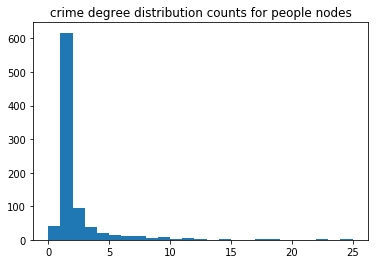

In [15]:
# plot distribution of crime degrees
plt.hist(d, bins = 25)
plt.title('crime degree distribution counts for people nodes')
plt.show()

**Crime Metrics In Bipartite Graph**

We now shift gears and degree measures for crime nodes in the bipartite graph:

In [16]:
# calculate degree for crime graph
d = sorted([round(v,3) for k,v in dict(nx.degree(G)).items() \
        if G.node[k]['bipartite'] == 'crimes'], reverse=True)


# calculate people degree centrality in bipartite graph
dc = sorted([round(v,3) for k,v in nx.degree_centrality(G).items() \
        if G.node[k]['bipartite'] == 'crimes'],reverse=True)

# people in sorted order by degree centrality
p = sorted([(k,round(v,3)) for k,v in nx.degree_centrality(G).items() \
        if G.node[k]['bipartite'] == 'crimes'],
       key= lambda z: z[1], reverse=True)
p = [name for name,val in p ]


# save degree metrics to df
crimesdf = pd.DataFrame({'crimes':p, 'degree_cent':dc, 'degree':d})

# top 10 people by degree cent and degree measures
print("top 10 crimes by degree:")
crimesdf[0:10]

top 10 crimes by degree:


,crimes,degree_cent,degree
0,970511,0.013,18
1,940103,0.011,15
2,940149,0.009,13
3,940150,0.009,13
4,950202,0.009,13
5,960290,0.008,12
6,970520,0.008,11
7,930043,0.006,9
8,930050,0.006,9
9,930063,0.006,9


The top 10 crimes by degree have between 9 and 18 individuals involved.  On the other hand, the bottom 10 crimes are associated with zero or one identified individuals.  


In [17]:
# bottom 10
print("bottom 10 crimes by degree:")
crimesdf[-10:]

bottom 10 crimes by degree:


,crimes,degree_cent,degree
547,970549,0.001,1
548,970550,0.001,1
549,970551,0.001,1
550,970552,0.001,1
551,970553,0.001,1
552,970554,0.001,1
553,930046,0.000,0
554,950203,0.000,0
555,960267,0.000,0
556,970555,0.000,0


Here is a histogram of crime nodes by degree:

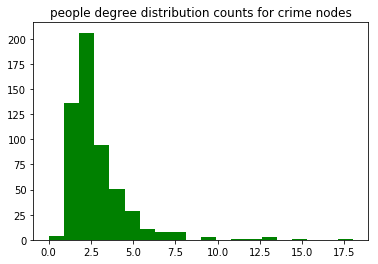

In [18]:
# plot distribution of crime degrees
plt.hist(d, bins = 20, color='g')
plt.title('people degree distribution counts for crime nodes')
plt.show()

Most crimes appear to have only a few associated individuals; However, there are a handful of crimes involving more than 10 individuals.

**People Affiliation Network**

We can create a unipartite representation of the people nodes.  To do this we assume there is an edge between two individuals if they were involved in the same crime.  We can also weight the edges to represent the total number of crimes node pair was affiliated with.

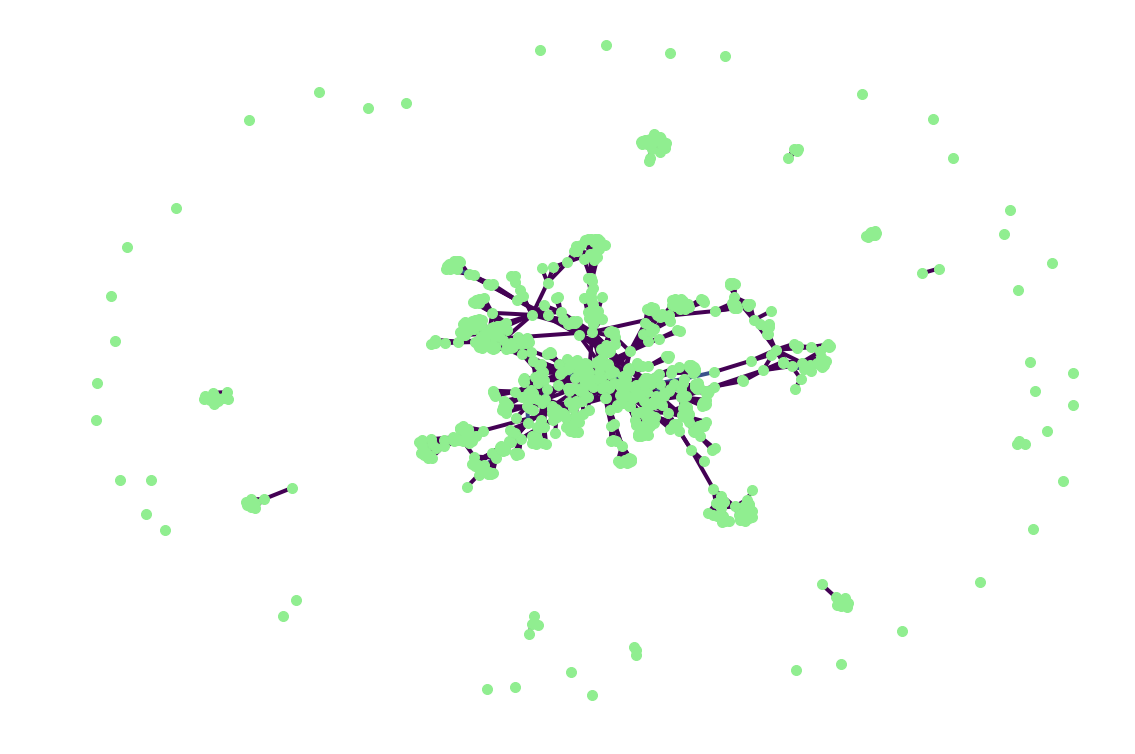

In [21]:
# isolate people nodes only
people_nodes = []
for n in G.nodes():
    if G.node[n]['bipartite'] == 'people':
        people_nodes.append(n)

# create unipartite graph object with people only
G_people = bipartite.weighted_projected_graph(G, people_nodes )

# edge weights are equal to number crimes people are involved in together
weights = [G_people[u][v]['weight'] for u,v in G_people.edges()]

# draw projected graph
plt.figure(figsize=(15,10))
nx.draw(G_people, with_labels=False, pos= nx.spring_layout(G_people), \
        node_color='lightgreen', \
        node_size = 100, width=4, font_size = 5, edge_color=weights)
        
plt.show()

Like the bipartite graph, the people affiliation graph is disconnected, with many isolated nodes.  There are a handful of small, connected clusters, and one large connected subgraph.  

Here is a summary of the top 10 people nodes by weighted degree:

In [22]:
# calculate  weighted degree for people unipartite graph
d = sorted([round(v,3) for k,v in dict(nx.degree(G_people, weight='weight')).items()], reverse=True)

# people in sorted order by degree 
p = sorted([(k,round(v,3)) for k,v in dict(nx.degree(G_people, weight='weight')).items()], \
           key= lambda z: z[1], reverse=True)
p = [name for name,val in p ]

# save degree metrics to df
p_uni = pd.DataFrame({'people':p,'degree':d})

# top 10 people by degree cent and degree measures
print("top 10 people by degree:")
p_uni[0:10]

top 10 people by degree:


,people,degree
0,KeaneArthur,65
1,AbramsChad,55
2,HemphillButch,49
3,SmothersFreddie,39
4,BendixJerryLee,37
5,StevensRico,37
6,MarionJoe,36
7,AlexanderNolan,30
8,WilsonMac,29
9,JeffersonBarbi,27


Seven of these individuals were also in the previous top 10 degree list depicting the number of crimes associated with each individual.  It makes sense that there is a correlation between the number of crimes committed, and the total number of individuals one is interacting with during the course of a crime. 

Let's review closeness centrality measures for the top 10 nodes:

In [23]:
# calculate top 10 closeness centrality for people
c = nx.closeness_centrality(G_people)
print('people closeness centrality:')
[(k,round(c[k],3)) for k in sorted(c, key=c.get, reverse=True)][0:10]

people closeness centrality:


[('SmithAnthony', 0.19),
 ('AbramsChad', 0.188),
 ('WilsonMac', 0.188),
 ('StevensRico', 0.187),
 ('HemphillButch', 0.186),
 ('KingstonRyan', 0.186),
 ('KatzLuella', 0.184),
 ('KeaneArthur', 0.182),
 ('KirklandRudy', 0.181),
 ('PaigeBobby', 0.18)]

There is less overlap in this top 10 list with the degree-related rankings.  Perhaps this list more closely reflects individuals associated with organized crime. 

Let's identify the boundary spanners:

In [24]:
# calculate betweenness centrality
b = nx.betweenness_centrality(G_people, weight='weight')
print('betweenness centrality;')
[(k,round(b[k],3)) for k in sorted(b, key=b.get, reverse=True)][0:10]

betweenness centrality;


[('WilsonMac', 0.328),
 ('SmithAnthony', 0.236),
 ('AbramsChad', 0.173),
 ('BendixJerryLee', 0.142),
 ('StevensRico', 0.141),
 ('KingstonRyan', 0.128),
 ('GuntherJamie', 0.116),
 ('HemphillButch', 0.109),
 ('KeaneArthur', 0.105),
 ('AndersonMitch', 0.097)]

Most of these names are familiar, although there are a couple new names:  GuntherJamie and AndersonMitch.  These two individuals are not associated with extremely high number of crimes, nor do they have many collaborators for crimes, but they  could be affiliated with multiple crime-commiting groups. 

Here are the top 10 eigenvector centrality measures:

In [25]:
# calculate eigenvector centrality
e = nx.eigenvector_centrality(G_people)
print('eigenvector centrality:')
[(k,round(e[k],3)) for k in sorted(e, key=e.get, reverse=True)][0:10]

eigenvector centrality:


[('KeaneArthur', 0.308),
 ('SmothersFreddie', 0.261),
 ('StevensRico', 0.225),
 ('BendixJerryLee', 0.215),
 ('BinderErrol', 0.209),
 ('Mobley,Sr.Lester', 0.208),
 ('WilliamsonBradford', 0.207),
 ('ParkerSebastian', 0.207),
 ('JamesMarla', 0.206),
 ('VestHiroko', 0.205)]

Outisde of a few familiar names, we are getting many new individuals with the eigenvector centrality measure. These new individuals could potentially be crime bosses who are influential in terms of criminal activity, but are not explicitly committing many crimes themselves. 

Finally, let's use the island method to look at nodes connected with weights of 2 or greater:

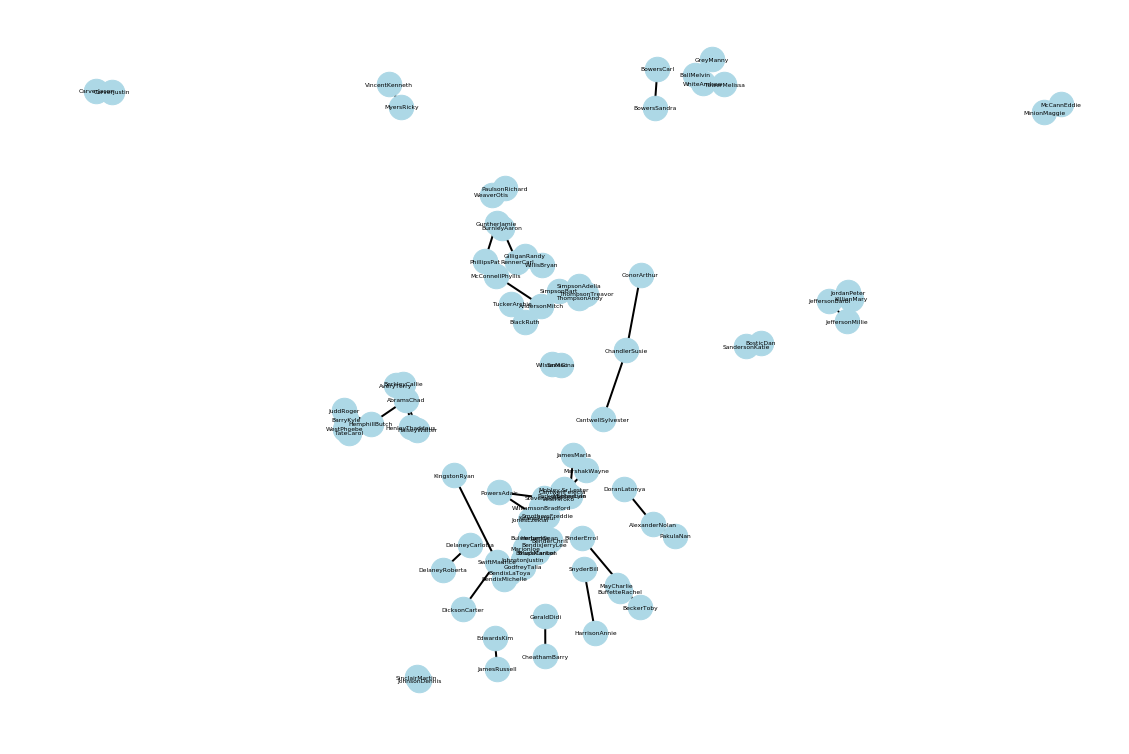

In [26]:
# trim graph function to only include edges in graph above specified weight
def trim_edges( g, weight = 1):
    g2 = nx.Graph()
    for f, to, edata in g.edges( data = True):
        if edata['weight'] > weight:
            g2.add_weighted_edges_from([(f, to, edata)])
    return g2

# use island method to focus on graphs with edge weights in excess of 1
G_people_trim = trim_edges(G_people,weight=1)

# draw graph
plt.figure(figsize=(15,10))
nx.draw(G_people_trim, with_labels=True, pos= nx.spring_layout(G_people), \
        node_color='lightblue',node_size = 600, width=2, font_size = 6, layout='pydot_layout')

Interestingly, this graph is not very disconnected.  We also tend to see only pairs and an occassional triad of nodes.

**Crime Affiliate Network**

Let's create a unipartite representation of the crime nodes. To do this we assume there is an edge between two crimes if the same person was involved in both crimes.

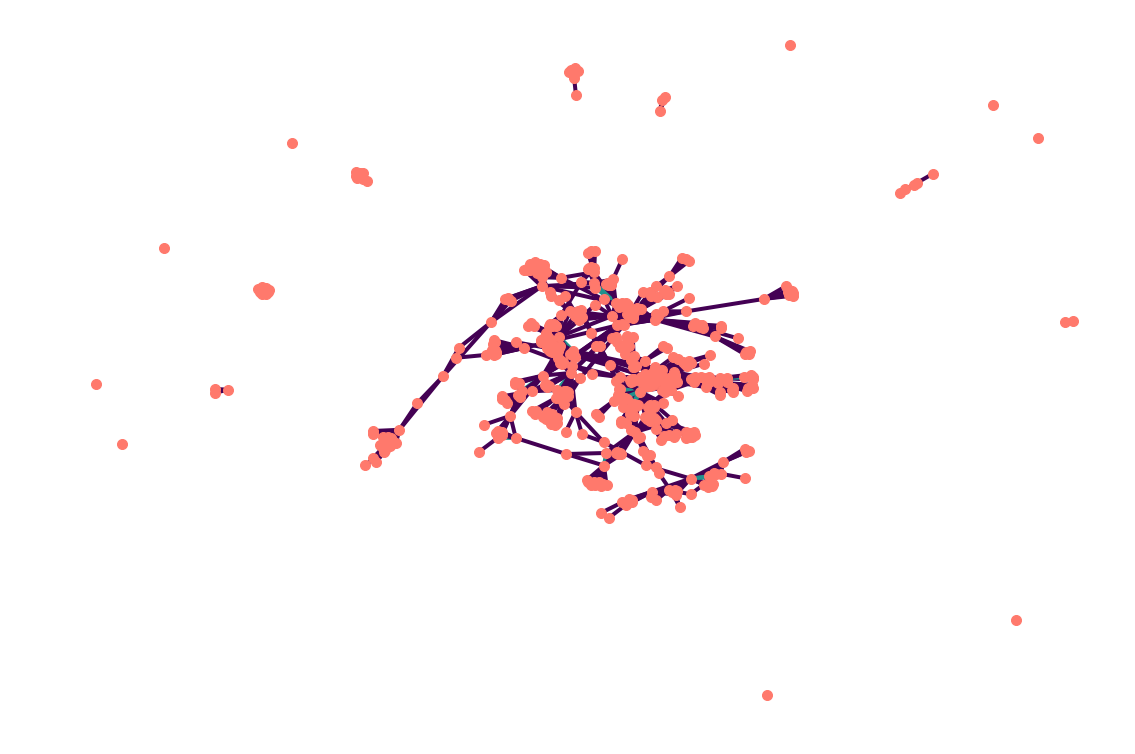

In [27]:
# isolate crime nodes only
crime_nodes = []
for n in G.nodes():
    if G.node[n]['bipartite'] == 'crimes':
        crime_nodes.append(n)

# create unipartite graph object with people only
G_crime = bipartite.weighted_projected_graph(G, crime_nodes )

# edge weights are equal to number crimes people are involved in together
weights = [G_crime[u][v]['weight'] for u,v in G_crime.edges()]

# draw projected graph
plt.figure(figsize=(15,10))
nx.draw(G_crime, with_labels=False, pos= nx.spring_layout(G_crime), \
        node_color='xkcd:salmon', \
        node_size = 100, width=4, font_size = 5, edge_color=weights,)
        
plt.show()

The crime affiliate network has a significant number of isolated nodes, and one very dense cluster.  Let's look at the top 10 crimes by weighted degree:

In [28]:
# calculate  weighted degree for people unipartite graph
d = sorted([round(v,3) for k,v in dict(nx.degree(G_crime, weight='weight')).items()], reverse=True)

# people in sorted order by degree centrality
p = sorted([(k,round(v,3)) for k,v in dict(nx.degree(G_crime, weight='weight')).items()], \
           key= lambda z: z[1], reverse=True)
p = [name for name,val in p ]

# save degree metrics to df
c_uni = pd.DataFrame({'crime':p,'degree':d})

# top 10 people by degree cent and degree measures
print("top 10 crimes by degree:")
c_uni[0:10]

top 10 crimes by degree:


,crime,degree
0,970511,94
1,940150,46
2,960331,43
3,960392,40
4,970401,39
5,970540,38
6,950202,37
7,970435,35
8,970535,35
9,960359,32


Here are closeness centrality measures:

In [30]:
# calculate top 10 closeness centrality for crimes
c = nx.closeness_centrality(G_crime)
print('crime closeness centrality:')
[(k,round(c[k],3)) for k in sorted(c, key=c.get, reverse=True)][0:10]

crime closeness centrality:


[('970401', 0.224),
 ('970521', 0.222),
 ('960392', 0.22),
 ('960286', 0.213),
 ('950202', 0.212),
 ('970540', 0.212),
 ('960341', 0.21),
 ('960344', 0.21),
 ('970494', 0.21),
 ('940150', 0.209)]

Only five of these crimes were listed in the top 10 list by degree count.

In [31]:
# calculate betweenness centrality for crimes
b = nx.betweenness_centrality(G_crime, weight='weight')
print('betweenness centrality:')
[(k,round(b[k],3)) for k in sorted(b, key=b.get, reverse=True)][0:10]

betweenness centrality:


[('970511', 0.301),
 ('970401', 0.292),
 ('960286', 0.192),
 ('970396', 0.175),
 ('960344', 0.171),
 ('970439', 0.168),
 ('960392', 0.166),
 ('970521', 0.162),
 ('970435', 0.15),
 ('970450', 0.12)]

Four of these nodes were not present in the top 10 degree or betweenness centrality measures.

In [32]:
# calculate eigenvector centrality, crimes
e = nx.eigenvector_centrality(G_crime)
print('eigenvector centrality: ')
[(k,round(e[k],3)) for k in sorted(e, key=e.get, reverse=True)][0:10]

eigenvector centrality: 


[('970401', 0.205),
 ('970435', 0.203),
 ('960359', 0.202),
 ('970521', 0.202),
 ('960375', 0.2),
 ('970494', 0.199),
 ('960332', 0.199),
 ('970526', 0.199),
 ('970400', 0.199),
 ('960278', 0.199)]

Roughly half of the top 10 eigenvector centrality nodes could be characterized as gray cardinals, as they do not appear in other centrality measures.

Now let's use the island method to trim the graph so that we are only plotting node pairs with weights over 1.

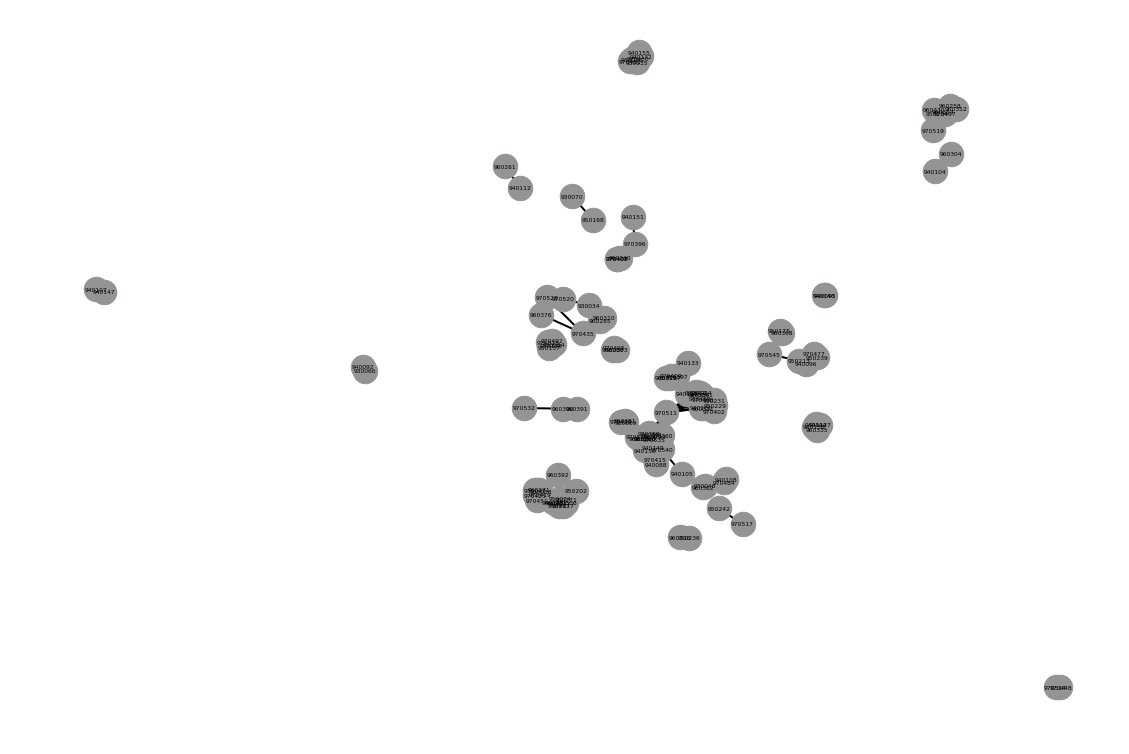

In [33]:
# use island method to focus on graphs with edge weights in excess of 1
G_crime_trim = trim_edges(G_crime,weight=1)

plt.figure(figsize=(15,10))
nx.draw(G_crime_trim, with_labels=True, pos= nx.spring_layout(G_crime), \
        node_color='xkcd:gray',node_size = 600, width=2, font_size = 6, layout='pydot_layout')

This graph is disconnected, with most nodes appearing in pairs only.

## Video Commentary

http://youtu.be/X0d9gNADu08?hd=1

## References

* Dataset: http://moreno.ss.uci.edu/data.html#crime
* technical tip on replacing parts of strings in numpy arrays: https://stackoverflow.com/questions/21385673/shortest-way-to-replace-parts-of-strings-in-numpy-array
* SNA book, trim function: Tsvetovat, Maksim; Kouznetsov, Alexander. Social Network Analysis for Startups: Finding connections on the social web (p. 64). O'Reilly Media. Kindle Edition.